In [1]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
import pymc3 as pm
np.set_printoptions(suppress=True)
import re

Using cuDNN version 7104 on context None
Mapped name None to device cuda0: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [158]:
data = pm.BetaBinomial.dist(.25, 5., 40).random(size = 200000)
#data = data[data != 0]
n = 40
print(n)

40


In [160]:
# Load the data and process it.

df = pd.read_csv("mturk_surveys.csv.1")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

df = df[df['period'] < 45]

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
data = data.groupby(['min', 'max', 'count']).size().reset_index(name='count_history')

NameError: name 'pd' is not defined

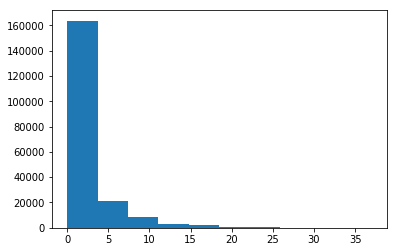

In [159]:
plt.hist(data);

In [150]:
with pm.Model() as model:
    a = pm.Uniform('alpha', 0., 1.)
    b = pm.Uniform('beta', 2, 10)
    dis1 = pm.BetaBinomial('betabin', a, b, n = n , observed=data)
    
# "Super fast Sampling" using ADVI
with model:
    inference = pm.ADVI(cost_part_grad_scale=pm.floatX(1))
    approx = inference.fit(n=20000)
    trace_vi = approx.sample(5000) 
    elbos1 = -inference.hist

Average Loss = 3.3901e+05: 100%|██████████| 20000/20000 [00:28<00:00, 708.71it/s]
Finished [100%]: Average Loss = 3.3901e+05


/Users/ded/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


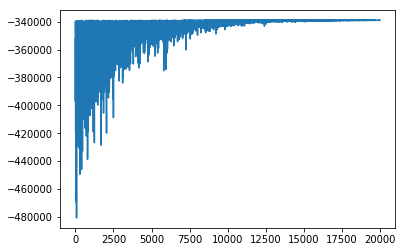

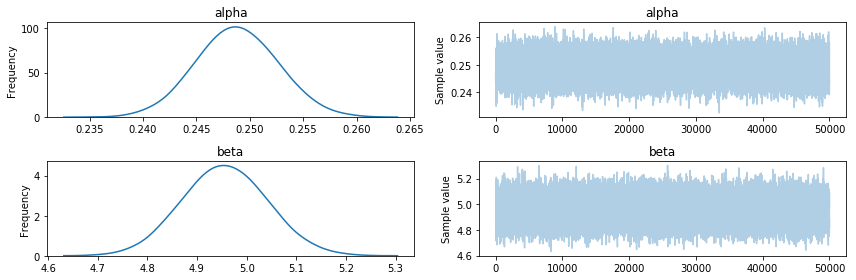

In [153]:
plt.plot(elbos1)
trace_vi = approx.sample(50000)
pm.traceplot(trace_vi);

[ 7  0  2  0  8 15  0  7  5  2  4  4  0 37  0 10  7  7  0  1  0  0  0 14
  0  3  0  0  0  0 12  3  0  3  4  1  2  0  0  0  0  0  1  0 21  0  0  0
  1  0  3  0  3  0  2 14  0  1  0  0  3  0 10  0  0  9  9  2  0  4  0 10
  0  9  0  0  3  4 18  0 50  0  6 78  0  7 23  0  0  1  0 16  3  0  0  7
  1  0  0  1]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta2, alpha2]
100%|██████████| 100500/100500 [04:00<00:00, 417.94it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha2,0.23,0.04,0.0,0.16,0.31,87788.76,1.0
beta2,4.47,1.09,0.0,2.46,6.62,87505.12,1.0


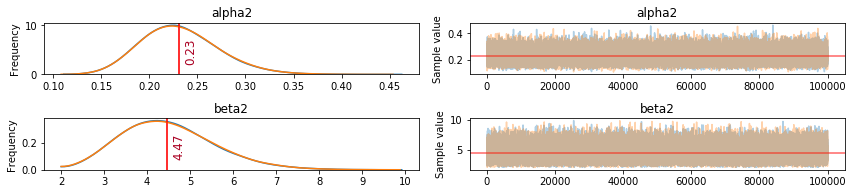

In [4]:
data2 = pm.BetaBinomial.dist(.25, 5., 100).random(size = 100)
print(data2)
with pm.Model() as model2:
    a2 = pm.Uniform('alpha2', 0., 1.)
    b2 = pm.Uniform('beta2', 2, 10)
    dis2 = pm.BetaBinomial('betabin2', a2, b2, n = 100 , observed=data2)
    post2 = pm.sample(100000, cores=1)
    
rvs = [rv.name for rv in strip_derived_rvs(model2.unobserved_RVs)]
plot_traces(post2, varnames=rvs);
pm.summary(post2).round(2)

[ 0  0  7 11 36  1  6  0  0 11 28  0  0  0  1 13  1  0  0  0  0  0  2  4
  0  0  0  0  5  1  6  0  0  2 11  0  0  0  0  0  1 11  3  0  1  0  0  9
  0  5  6 10  0  1  0  0  0  1  4 12  0  0  0  0 14  0  0 10  0 15  1  0
 60 29  0 20  0  1  9  0 35  1  9  2  0  1  1 14  8 22  0  2  0  1  0  1
  5  0  0  2  0 34  0  0 14  0  3  0  6  7 10  0  9  0  1  3 10  4  1 35
  4  0  2  2  1 17  1  0 37  0  1  6  0  0  0  0  1  0 20  3  0  8  0  0
 14  0  1  0 24  0  1  0  5 30  0 15 18  0  0  0  9  0  0  3  0  0  6  3
  0  6  7  0  0  0  0  0  2  1  0  2  8  3  5  4  0  1  4  0  0  3  0 34
  0  1  0  0  4 17  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  1
  5  0  0  0  7  0  2  0 22  1  0  0  0  7  2  0  5  0  2  0  0  1  0  0
  5  0  1 16 46  1  0 16  2 24  8  0 14 19  0  0 15  0  0  0  0  0  1  0
  0  0  9  0  0  0  1  3  1  3  2  0  0  0  3  0  0  0  2  1  0  1  0  1
  3  4  0  0  0  3  0  0  1  0  1  0 18 13 14  5  5  0  1 30 12  0  1  1
  0  1  0  0  0  2  2  0  1  1  0  0  1  0  7  0  8

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta3, alpha3]
100%|██████████| 100500/100500 [05:31<00:00, 303.59it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha3,0.25,0.01,0.0,0.22,0.28,89700.69,1.0
beta3,5.42,0.43,0.0,4.58,6.27,88552.68,1.0


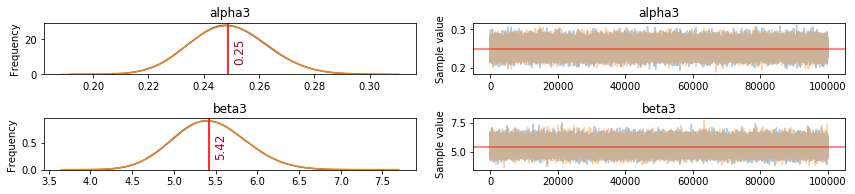

In [9]:
data3 = pm.BetaBinomial.dist(.25, 5., 100).random(size = 1000)
print(data3)
with pm.Model() as model3:
    a3 = pm.Uniform('alpha3', 0., 1.)
    b3 = pm.Uniform('beta3', 2, 10)
    dis3 = pm.BetaBinomial('betabin2', a3, b3, n = 100 , observed=data3)
    post3 = pm.sample(100000, cores=1)
    
rvs = [rv.name for rv in strip_derived_rvs(model3.unobserved_RVs)]
plot_traces(post3, varnames=rvs);
pm.summary(post3).round(2)

[ 0  0  0 ... 17  0  3]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta4, alpha4]
100%|██████████| 100500/100500 [04:05<00:00, 409.13it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha4,0.26,0.00,0.0,0.25,0.26,88452.56,1.0
beta4,5.18,0.13,0.0,4.92,5.43,85343.93,1.0


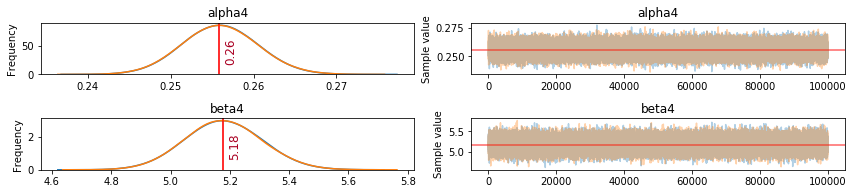

In [7]:
data4 = pm.BetaBinomial.dist(.25, 5., 100).random(size = 10000)
print(data4)
with pm.Model() as model4:
    a4 = pm.Uniform('alpha4', 0., 1.)
    b4 = pm.Uniform('beta4', 2, 10)
    dis4 = pm.BetaBinomial('betabin4', a4, b4, n = 100 , observed=data4)
    post4 = pm.sample(100000, cores=1)
rvs = [rv.name for rv in strip_derived_rvs(model4.unobserved_RVs)]
plot_traces(post4, varnames=rvs);
pm.summary(post4).round(2)

[0 0 2 ... 0 0 8]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta5, alpha5]
100%|██████████| 100500/100500 [26:03<00:00, 64.28it/s]
The acceptance probability does not match the target. It is 0.8856304786098411, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9030162723068695, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha5,0.25,0.00,0.0,0.24,0.25,74972.75,1.0
beta5,4.94,0.04,0.0,4.86,5.01,73882.80,1.0


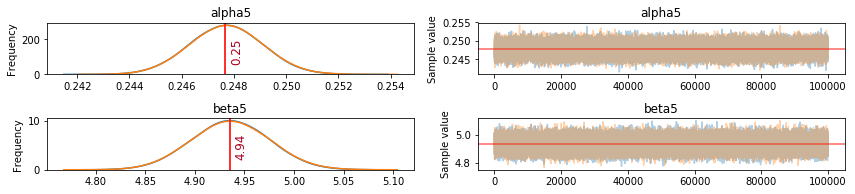

In [8]:
data5 = pm.BetaBinomial.dist(.25, 5., 100).random(size = 100000)
print(data5)
with pm.Model() as model5:
    a5 = pm.Uniform('alpha5', 0., 1.)
    b5 = pm.Uniform('beta5', 2, 10)
    dis5 = pm.BetaBinomial('betabin5', a5, b5, n = 100 , observed=data5)
    post5 = pm.sample(100000, cores=1)
rvs = [rv.name for rv in strip_derived_rvs(model5.unobserved_RVs)]
plot_traces(post5, varnames=rvs);
pm.summary(post5).round(2)

### With more individuals we can recover the alpha/beta parameters!
### Let's try if we actually need many samples?

[0 2 0 ... 0 2 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta5, alpha5]
100%|██████████| 10500/10500 [00:45<00:00, 229.79it/s]
The acceptance probability does not match the target. It is 0.8989589784336875, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9099156596631188, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha5,0.25,0.00,0.0,0.25,0.25,15454.06,1.0
beta5,5.05,0.04,0.0,4.97,5.12,15646.84,1.0


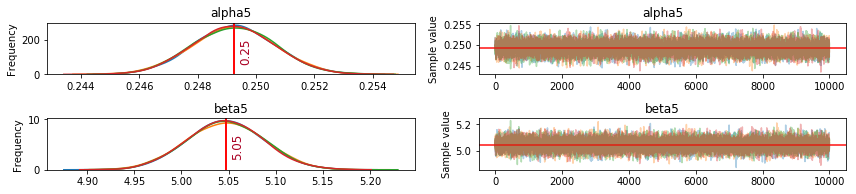

In [6]:
data5 = pm.BetaBinomial.dist(.25, 5., 100).random(size = 100000)
print(data5)
with pm.Model() as model5:
    a5 = pm.Uniform('alpha5', 0., 1.)
    b5 = pm.Uniform('beta5', 2, 10)
    dis5 = pm.BetaBinomial('betabin5', a5, b5, n = 100 , observed=data5)
    post5 = pm.sample(10000, chains = 4, cores=1)
rvs = [rv.name for rv in strip_derived_rvs(model5.unobserved_RVs)]
plot_traces(post5, varnames=rvs);
pm.summary(post5).round(2)

In [28]:
import numpy as np
from scipy.stats import binom, beta
np.random.seed(42)
''' we have values of X and n '''
n_data = np.random.randint(10, 30, size=1000)
x_data = binom.rvs(n _data, beta.rvs(10, 20, size=1000))

(array([ 42., 159., 244., 231.,  86., 111.,  83.,  30.,  13.,   1.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <a list of 10 Patch objects>)

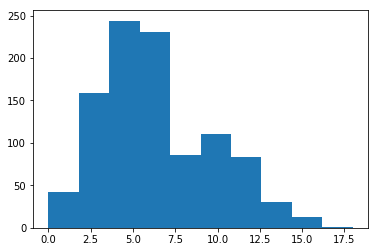

In [36]:
plt.hist(x_data)

In [86]:
binom.rvs(np.array([1,2,3]), beta.rvs(10, 20, size=3))

array([0, 0, 0])

In [116]:
pm.Bi

[ 0 28]
[ 0 27]
[ 1 23]
[ 0 19]
[ 2 24]
[ 0 23]
[ 4 23]
[ 3 26]
[ 6 21]
[ 3 25]
[ 0 23]
[ 3 20]
[ 4 24]
[ 4 25]
[ 3 25]
[ 4 25]
[ 6 28]
[ 3 22]
[ 3 22]
[ 2 23]
[ 1 22]
[ 3 20]
[ 2 25]
[ 1 23]
[ 4 19]
[ 4 24]
[ 3 28]
[ 5 24]
[ 1 24]
[ 3 26]
[ 3 23]
[ 3 29]
[ 2 22]
[ 3 27]
[ 4 22]
[ 6 27]
[ 2 25]
[ 0 25]
[ 0 26]
[ 1 22]
[ 5 24]
[ 2 21]
[ 2 28]
[ 1 24]
[ 2 21]
[ 2 27]
[ 6 26]
[ 3 26]
[ 3 20]
[ 0 26]
[ 0 25]
[ 1 24]
[ 3 26]
[ 4 23]
[ 1 27]
[ 3 23]
[ 2 26]
[ 2 25]
[ 2 24]
[ 3 24]
[ 2 25]
[ 1 23]
[ 3 26]
[ 2 22]
[ 0 27]
[ 2 21]
[ 2 28]
[ 3 22]
[ 2 23]
[ 2 26]
[ 4 27]
[ 3 21]
[ 7 26]
[ 2 24]
[ 2 27]
[ 1 27]
[ 8 21]
[ 8 26]
[ 0 27]
[ 2 23]
[ 6 27]
[ 2 24]
[ 3 25]
[ 2 24]
[ 3 25]
[ 1 25]
[ 1 28]
[ 2 26]
[ 2 25]
[ 7 24]
[ 3 27]
[ 2 22]
[ 5 26]
[ 2 25]
[ 3 23]
[ 2 27]
[ 1 25]
[ 1 24]
[ 4 21]
[ 3 27]


In [126]:
data = pm.BetaBinomial.dist(0.2,  5, 40).random(size = 20000)

INFO (theano.gof.compilelock): Refreshing lock /Users/ded/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir/lock


(array([17071.,  1389.,   747.,   370.,   210.,   132.,    45.,    25.,
            8.,     3.]),
 array([ 0. ,  3.2,  6.4,  9.6, 12.8, 16. , 19.2, 22.4, 25.6, 28.8, 32. ]),
 <a list of 10 Patch objects>)

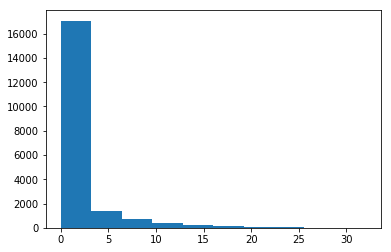

In [127]:
plt.hist(data)

In [129]:
with pm.Model() as model0:
    alpha0 = pm.Uniform('alpha', 0, 100)
    beta0 = pm.Uniform('beta', 0, 100)
    X0 = pm.BetaBinomial('X', alpha=alpha0, beta=beta0, n=40, observed=data)

# "Super fast Sampling" using ADVI
with model0:
    inference = pm.ADVI(cost_part_grad_scale=pm.floatX(1))
    approx = inference.fit(n=50000)
    trace_vi = approx.sample(5000) 
    elbos1 = -inference.hist

Average Loss = 29,825: 100%|██████████| 50000/50000 [00:51<00:00, 974.65it/s]    
Finished [100%]: Average Loss = 29,825


/Users/ded/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


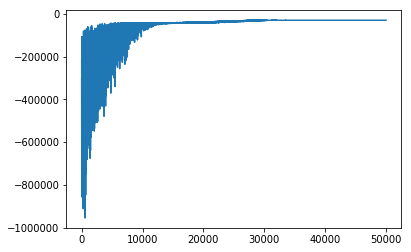

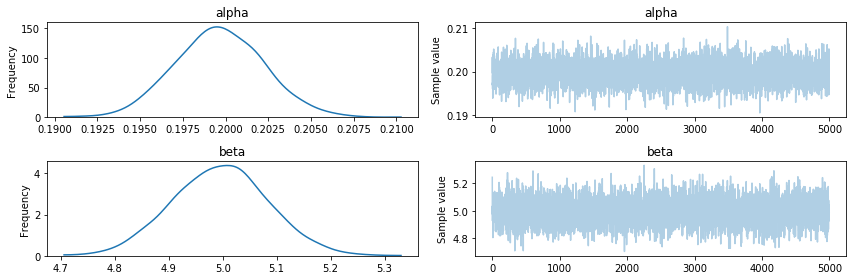

In [130]:
plt.plot(elbos1)
trace_vi = approx.sample(5000)
pm.traceplot(trace_vi);

In [157]:
np.arange(1,40+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])